In [1]:
from pilot import *
%matplotlib inline
plt.style.use("ggplot")

weights: initializing weights with stddev = 0.020000
(Generator/FC1) Adding param "Generator/FC1/w" with shape: (200, 8192)
(Generator/FC1) Creating outputs with shapes: (1, 8192)
(Generator/Scale1) Creating outputs with shapes: (1, 8192)
(Generator/EltwiseSum1) Creating outputs with shapes: (1, 8192)
(Generator/BatchNorm1) Adding param "Generator/BatchNorm1/count" with shape: ()
(Generator/BatchNorm1) Adding param "Generator/BatchNorm1/mean" with shape: (8192,)
(Generator/BatchNorm1) Adding param "Generator/BatchNorm1/var" with shape: (8192,)
(Generator/BatchNorm1) Creating outputs with shapes: (1, 8192)
(Generator/Gain1) Adding param "Generator/Gain1/g" with shape: (8192,)
(Generator/Gain1) Creating outputs with shapes: (1, 8192)
(Generator/Bias1) Adding param "Generator/Bias1/b" with shape: (8192,)
(Generator/Bias1) Creating outputs with shapes: (1, 8192)
(Generator/ReLU1) Creating outputs with shapes: (1, 8192)
(Generator/Reshape1) Creating outputs with shapes: (1, 512, 4, 4)
weigh

(Generator/Bias4) Creating outputs with shapes: (1, 64, 32, 32)
(Generator/ReLU4) Creating outputs with shapes: (1, 64, 32, 32)
weights: initializing weights with stddev = 0.020000
(Generator/Deconv4) Reusing param "Generator/Deconv4/w" with shape: (64, 3, 5, 5)
(Generator/Deconv4) Creating outputs with shapes: (1, 3, 64, 64)
(Generator/Sigmoid1) Creating outputs with shapes: (1, 3, 64, 64)
WEIGHTS LOADED...


# Pilot experiment

Run the following cell to begin.

In [59]:
#np.random.choice([10, 50, 100, 200])
ndims=200
std = 0.25
config = get_config(nblocks=3, ntrials=10, std=std, ndims=ndims, print_feedback=True)
blocks = get_blocks(config)
pilot_experiment(blocks, config)

Thank you for completing this experiment!
Correct: 0.9667























# Viz

11.4129161965


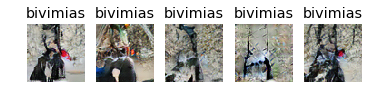

In [42]:
config = get_config(nblocks=1, ntrials=5, std=0.25, ndims=200, print_feedback=False)
print(config.dist)
examples1 = [get_mean_example(config, 'bivimias') for _ in range(config.ntrials)]
imshows([x['img'] for x in examples1], labels=[x['category'] for x in examples1])

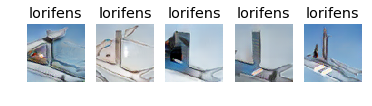

In [43]:
examples1 = [get_mean_example(config, 'lorifens') for _ in range(config.ntrials)]
imshows([x['img'] for x in examples1], labels=[x['category'] for x in examples1])

# Export experiment

In [60]:
import time
from glob import glob

# export experiment
logdir = os.path.join(os.getcwd(), 'logs')

if experiment_is_complete(blocks):
    outdir = os.path.join(logdir, (  "std-" + str(std)
                                   + "-ndims-" + str(ndims)
                                   + "-timestamp-" + str(int(time.time()))))
    !mkdir -p {outdir}
    
    print("Logging experiment to %s" % outdir)

    np.savez(os.path.join(outdir, "config.npz"), **config)
    np.savez(os.path.join(outdir, "blocks.npz"), *blocks)
else:
    print("Experiment is incomplete, not logging.")

Logging experiment to /home/ubuntu/dimensionality/notebooks/logs/std-0.25-ndims-200-timestamp-1544137994


# Analysis

In [61]:
def get_acc_per_block(outdir):
    # config = dict(np.load(os.path.join(outdir, "config.npz")).items())
    blocks = [
        list(x) for _, x in
        sorted(np.load(
            os.path.join(outdir, "blocks.npz")
        ).items())
    ]
    assert experiment_is_complete(blocks)
    acc_per_block = []
    for block in blocks:
        acc = np.mean([
            x["category"] == x["predicted_category"]
            for x in block
        ])
        acc_per_block.append(acc)
    return acc_per_block

from glob import glob
acc_per_block_200 = np.array([get_acc_per_block(x) for x in glob(os.path.join(logdir, "*ndims-200-*"))])
acc_per_block_100 = np.array([get_acc_per_block(x) for x in glob(os.path.join(logdir, "*ndims-100-*"))])
acc_per_block_50 = np.array([get_acc_per_block(x) for x in glob(os.path.join(logdir, "*ndims-50-*"))])

In [62]:
glob(os.path.join(logdir, "*ndims-200-*"))

['/home/ubuntu/dimensionality/notebooks/logs/std-0.25-ndims-200-timestamp-1544137994']

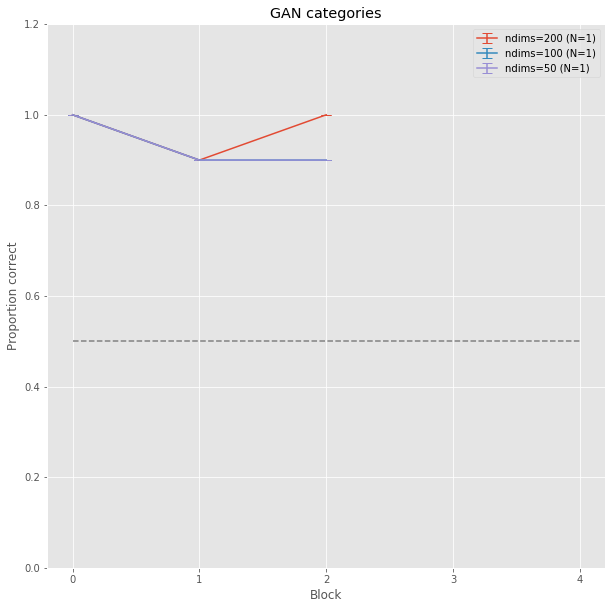

In [63]:
from scipy import stats
plt.figure(figsize=(10., 10.))

# TODO: plot mean and error bars instead.

mean_200 = np.mean(acc_per_block_200, axis=0)
std_200 = np.std(acc_per_block_200, axis=0)
sem_200 = stats.sem(acc_per_block_200, axis=0, ddof=0)
N_200 = acc_per_block_200.shape[0]
plt.errorbar(
    range(len(mean_200)),
    mean_200,
    sem_200,
    capsize=5,
    label="ndims=200 (N=%d)" % N_200
)

mean_100 = np.mean(acc_per_block_100, axis=0)
std_100 = np.std(acc_per_block_100, axis=0)
sem_100 = stats.sem(acc_per_block_100, axis=0, ddof=0)
N_100 = acc_per_block_100.shape[0]
plt.errorbar(
    range(len(mean_100)),
    mean_100,
    sem_100,
    capsize=5,
    label="ndims=100 (N=%d)" % N_100
)

mean_50 = np.mean(acc_per_block_50, axis=0)
std_50 = np.std(acc_per_block_50, axis=0)
sem_50 = stats.sem(acc_per_block_50, axis=0, ddof=0)
N_50 = acc_per_block_50.shape[0]
plt.errorbar(
    range(len(mean_50)),
    mean_50,
    sem_50,
    capsize=5,
    label="ndims=50 (N=%d)" % N_50
)
    
plt.plot([0, 4], [0.5, 0.5], color='gray', linestyle="--")
    
plt.xticks(range(0, 5))
plt.xlabel("Block")

plt.ylim(0., 1.2)
plt.ylabel("Proportion correct")

plt.title("GAN categories")
    
plt.legend()
plt.show()

In [66]:
import seaborn as sns
import pandas as pd

# good coding alex!
df = pd.DataFrame(sum([sum([[{
    "block": i,
    "accuracy": acc,
    "ndims": ndims
} for i, acc in enumerate(accs)]
    for accs in acc_per_block], [])
 for ndims, acc_per_block in {
     200: acc_per_block_200,
     100: acc_per_block_100,
     50: acc_per_block_50
 }.items()], []))

plt.figure(figsize=(8., 8.))
ax = sns.boxplot(
    x="block",
    y="accuracy",
    hue="ndims",
    data=df,
    palette="Set3"
)
    
plt.xticks(range(0, 5))
plt.xlabel("Block")

plt.ylim(0.5, 1.05)
plt.ylabel("Proportion correct")

plt.title("GAN categories")
plt.show()

ImportError: this version of pandas is incompatible with numpy < 1.9.0
your numpy version is 1.8.2.
Please upgrade numpy to >= 1.9.0 to use this pandas version